Importo tutte le librerie necessarie

In [1]:
#Import all necessary libraries
import numpy as np
import os
import glob
import cv2 as cv2 #openCV library

import keras as ks #cnn library
#Some functionality
from keras.models import Sequential #to create a model with layer
#function for model creation
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
from keras.callbacks import EarlyStopping #to stop training
from sklearn.model_selection import train_test_split #to split train set
from keras.utils import to_categorical #for create a categorical image

#to plot some results
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf #For cnn
import seaborn as sn

Definisco la funzione per prelevare le immagini e creare il dataset


In [2]:
#Function to read all image from some path
def read_image_from(path, label): 
    y = [] #type of image
    x = [] #image

    for idx, i in enumerate(label):
        for im in glob.glob(path + '/' + i + '/*.jpg', recursive=True):
            # color conversion to black and white images
            x.append(cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2GRAY))
            y.append(idx)

    return x, y

In [3]:
#function to reshape all images
def reshape_image(x, width, height, channel):
    # Using anisotropic rescaling, resize the images to 64x64 in order to feed them to the network
    x = np.array([cv2.resize(im, (width, height), interpolation=cv2.INTER_AREA) for im in x])
    x = np.array([np.reshape(im, (width, height, channel)) for im in x]) #per rendere l'array nuovamente conitnuo

    # normalize the images
    x = x / 255

    return x

Inizio a creare le variabili di lavoro

In [4]:
#path to the directories [Adriano]
PATH_TRAIN=r'C:\Users\adria\Desktop\CVPR\Imageset\train'
PATH_TEST=r'C:\Users\adria\Desktop\CVPR\Imageset\test'

#path to the directories [Giovanni]
#PATH_TRAIN=r''
#PATH_TEST=r''

#Alternately Path
#PATH_TRAIN=r''
#PATH_TEST=r''

#Get all labels of train and test sets
labels=[os.path.basename(i) for i in glob.glob(PATH_TRAIN + '/*', recursive=True)]
num_classes = len(labels) #15
print("Classes number are: ", num_classes)
print("Class names: ", labels)

Classes number are:  15
Class names:  ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


In [5]:
#Read all images for test and train
X_train_raw, y_train_raw = read_image_from(PATH_TRAIN, labels) #get train dataset
X_test, y_test = read_image_from(PATH_TEST, labels) #get test dataset 
print('Image Dimensions : ',X_test[0].shape)
print('len train x: ',len(X_train_raw))
print('len test x: ',len(X_test))
print('len train y: ',len(y_train_raw))
print('len test y: ',len(y_test))

Image Dimensions :  (200, 276)
len train x:  1500
len test x:  2985
len train y:  1500
len test y:  2985


In [6]:
#For test if the images has been read Uncomment the following lines
#cv2.imshow("Immagine iniziale", X_train_raw[0])
#cv2.waitKey(0)
#cv2.destroyAllWindows() 

#the last two lines are necessary otherwise cv2 crash

Asintropic reduction of images

In [7]:
#Reshape the image with correct size for the cnn (max 128)
X_train_raw = reshape_image(X_train_raw, width = 64, height = 64, channel = 1)
X_test = reshape_image(X_test, width = 64, height = 64, channel = 1)
print("Reshaped image")

Reshaped image


In [8]:
#transform y_raw in to categorical matrix using keras.utils.to_categorical
y_train_one_hot = to_categorical(y_train_raw) #from vector to binary class matrix
y_test_one_hot = to_categorical(y_test)

Now y is:  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


Create a new dataset

In [9]:
#using sklearn.model function to split training set between train 85% and validation set 15%
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_raw, y_train_one_hot, train_size=0.85, random_state=42)
print('Train set dimintion: ',len(X_train))
print('Validation set dimintion: ',len(X_validation))
print('Test set dimintion: ',len(X_test))

Train set dimintion:  1275
Validation set dimintion:  225
Test set dimintion:  2985


Model Definition and Model Training

In [10]:
#necessario randomizzare, ottimizzare, creare il modello con sequential 
#ed inserire le vaire matrici di convoluzione

#keras.initializers.RandomNormal = inizializza e genera un tensor con distribuuzione normale
#      -mean, standard deviation, seed

#keras.optimizers.SGD = Crea un gradiente discendente ottimizzato
#      -learning_rate, momento = accellerazione della discesa, 
#      -nasterov = valore per il momento, nome = nome opzionale per il gradiente
#      -**kwargss = parole chiavi per gli argomenti

#keras.Sequential() = ragruppa i layers in un modello, possiamo inserire una
#   lista di layer al proprio interno o utilizzare la funzione .add. Possiamo
#   assegnare un nome al modello
#mkeras.model.compile = dal gruppo di layer in un oggetto


#For Sequential model we need:
#-Conv2D = for convolution layer. This layer creates a convolution kernel 
#     that is convolved with the layer input to produce a tensor of output. 
#     For use it we need a resharp of images
#
#-MaxPooling2D = downsamples the input representation by taking the maximum value 
#     over the window defined by pool_size.



In [11]:
#normalizzazione e ottimizzazione del modello
norm = ks.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
stochastic_gradient = ks.optimizers.SGD(momentum=0.9, nesterov=True)

In [12]:
#Model creation adding all layers
base_model = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 3,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    #set the initial bias values to 0
    Dense(num_classes, activation='softmax',kernel_initializer=norm, bias_initializer='zeros')
])
print("Model summary")
base_model.summary()
#recompile the model (teoricamente non credo ci sia di bisogno perché aggiungiamo
# tutti i layers direttamente sul sequential, ma nel dubbio lo faccio)
base_model.compile(loss='categorical_crossentropy', optimizer=stochastic_gradient, metrics = ['accuracy'])
print("Model summary after compiling")
base_model.summary()

Model summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16

Training and visualizzation of values


In [13]:
#keras.EarlyStopping = to stop training quando una meterica non mostra miglioramento 
es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.10)
batch_sz = 32 #number of samples for feed the network
#Train la cnn costruita precedentemente
#x = input data, y = target data, banch size = Number of samples per gradient update
#epochs = Number of epochs to train the model
#callbacks = List of callbacks to apply during training
#validation_data = Data on which to evaluate the loss and any model metrics at the end of each epoch
#shuffle = shuffle the training data before each epoch

base_history = base_model.fit(
    X_train,
    y_train,
    batch_size = batch_sz,
    epochs=100,
    validation_data=(X_validation, y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/100
40/40 [==============================] - 3s 57ms/step - loss: 2.7075 - accuracy: 0.0719 - val_loss: 2.7064 - val_accuracy: 0.0489
Epoch 2/100
40/40 [==============================] - 1s 29ms/step - loss: 2.6999 - accuracy: 0.0880 - val_loss: 2.6798 - val_accuracy: 0.0933
Epoch 3/100
40/40 [==============================] - 1s 28ms/step - loss: 2.6508 - accuracy: 0.1395 - val_loss: 2.5519 - val_accuracy: 0.1689
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 2.4830 - accuracy: 0.2134 - val_loss: 2.4660 - val_accuracy: 0.2356
Epoch 5/100
40/40 [==============================] - 1s 28ms/step - loss: 2.2608 - accuracy: 0.3301 - val_loss: 2.3473 - val_accuracy: 0.2400
Epoch 6/100
40/40 [==============================] - 1s 28ms/step - loss: 2.3515 - accuracy: 0.2503 - val_loss: 2.4399 - val_accuracy: 0.2311
Epoch 7/100
40/40 [==============================] - 1s 28ms/step - loss: 2.1701 - accuracy: 0.3401 - val_loss: 2.4741 - val_accuracy: 0.2222
Epoch 

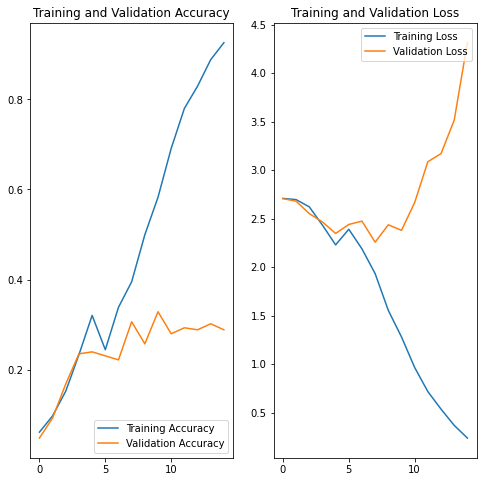

In [14]:
#add some graph use some function
acc = base_history.history['accuracy']
val_acc = base_history.history['val_accuracy']
loss = base_history.history['loss']
val_loss = base_history.history['val_loss']
ranges=range(len(acc))

#plot og traning and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(ranges, acc, label='Training Accuracy')
plt.plot(ranges, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ranges, loss, label='Training Loss')
plt.plot(ranges, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Valutazione del modello utilizzando la libreria

In [15]:
#Evaluate the model using test sets
base_loss, base_accuracy = base_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(base_loss))
print("accuracy: {:.2f}".format(base_accuracy))


94/94 [==============================] - 1s 8ms/step - loss: 3.9625 - accuracy: 0.3300
loss: 3.96
accuracy: 0.33


In [16]:
#predict

# https://androidkt.com/get-class-labels-from-predict-method-in-keras/#:~:text=in%20an%20image.-,model.,a%20dog%20or%20a%20cat).
#from multiclass classification
#predict_classes = X, batch_size=32, verbose=0
#Generate class predictions for the input samples and return a numpy array
#of class predictions
#Siccome l'hanno rimossa perché vecchia è necessaro seguire un altro metodo
#per ottenere il risultato a noi interessato -> guardare il link
#y_pred_base = base_model.predict_classes(X_test) #is deprecated and removed so
#use other funciont

#When we use model.predict we obtain the array contains the probability that the image belongs to each class
predictions = base_model.predict(X_test)
print("Prediction: ", predictions) #list of array 

Prediction:  [[1.6165398e-03 4.8117486e-06 2.9336104e-01 ... 4.6698954e-02
  1.4002540e-03 2.0362571e-04]
 [2.4072477e-01 7.0196076e-04 1.6964972e-03 ... 2.6758369e-05
  1.8887521e-07 5.7707396e-03]
 [1.5785605e-02 1.4681388e-04 4.2224026e-04 ... 7.5479056e-06
  4.1544649e-07 1.4561691e-04]
 ...
 [2.6026829e-03 1.7784679e-02 1.6504924e-01 ... 2.0397325e-01
  3.4706740e-05 2.4866540e-02]
 [7.5640064e-01 2.0955292e-10 5.4129910e-06 ... 1.2764230e-04
  7.0707296e-04 1.2514364e-02]
 [7.6368104e-07 1.0156400e-13 4.1451460e-07 ... 4.3394834e-09
  5.1497836e-06 2.6112613e-01]]


Print some information

In [26]:
#save the best classification for all prediction
classification = list() 
for x in predictions: #per ricondurci alla predict_class form
    classification.append(np.argmax(x))

In [27]:
print('Classification Report')
print(classification_report(y_test, classification, target_names=labels))

Classification Report
              precision    recall  f1-score   support

     Bedroom       0.16      0.23      0.19       116
       Coast       0.41      0.53      0.46       260
      Forest       0.31      0.33      0.32       228
     Highway       0.46      0.60      0.52       160
  Industrial       0.21      0.20      0.21       211
  InsideCity       0.21      0.23      0.22       208
     Kitchen       0.11      0.08      0.09       110
  LivingRoom       0.24      0.17      0.20       189
    Mountain       0.28      0.35      0.31       274
      Office       0.24      0.35      0.28       115
 OpenCountry       0.47      0.29      0.36       310
       Store       0.23      0.29      0.26       215
      Street       0.63      0.45      0.52       192
      Suburb       0.54      0.39      0.45       141
TallBuilding       0.49      0.35      0.41       256

    accuracy                           0.33      2985
   macro avg       0.33      0.32      0.32      2985
weig

Make plot of confusion matrix

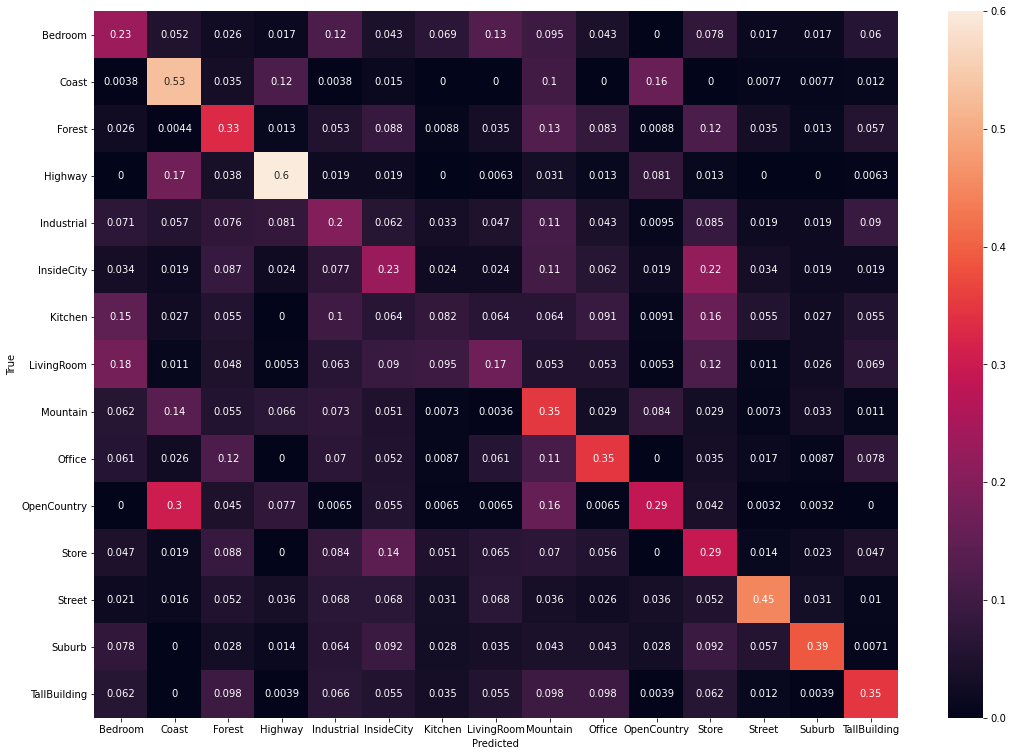

In [28]:
#compute and print confusion matrix
conf_matr = confusion_matrix(y_test, classification)
#dobbiamo normalizzare la matrice
conf_matr = tf.cast(conf_matr, dtype=tf.float32)
conf_matr = conf_matr / tf.math.reduce_sum(conf_matr, axis=1)[:, np.newaxis]

plt.figure(figsize=(18, 13))
sn.heatmap(conf_matr, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()